# Optimization with State-Dependent-Constraint (Non-Hermitian Hamiltonian)

We consider the optimization CPH0013 from Transmon2013 (see Fig 5.6 in thesis, point at $T = 500$ ns). This optimization was particularly afflicted with the problem of high cavity excitation. We repeat the optimization with a current version of QDYN and the Transmon program to ensure reproducability, and then run optimization with strong decay of the cavity, modeled by a non-Hermitian Hamiltonian.

This provides a valid test of the optimization methods, despite several caveats of the setup:

*   rectangular pulse shape
*   Qubits encoded in the bare frame
*   guess pulse unrealistically weak
*   no RWA (although validity of the RWA is highly questionable)
*   constant coupling of $J = 5$ MHz of the qubits

## Setup
[Skip](#Cavity-Excitation-Induced-by-Guess-Pulse)

In [1]:
%install_ext http://raw.github.com/goerz/version_information/master/version_information.py
%reload_ext version_information
% version_information numpy, matplotlib, pandas, QDYN, QDYNTransmonLib, \
 "cd $$PREFIX/src/qdyn && git log",  "cd $$PREFIX/src/transmon_oct && git log"

Installed version_information.py. To use it, type:
  %load_ext version_information


Software,Version
Python,2.7.10 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,3.1.0
OS,Linux 3.13.0 45 generic x86_64 with debian jessie sid
numpy,1.9.2
matplotlib,1.4.3
pandas,0.16.1
QDYN,0.1.0
QDYNTransmonLib,1.0.2
cd $PREFIX/src/qdyn && git log,commit f1e3bb93036a3c00abde0151279eebcf6cc605fb
cd $PREFIX/src/transmon_oct && git log,commit 72d26c92b2f6cb55849c4db8b1d42155d05ddb16


In [2]:
% matplotlib inline

In [3]:
from IPython.parallel import Client
try:
    cluster = Client()[:] # view on all cluster engines
    #cluster = Client()[:] # view on all cluster engines
    print "%d engines available" % len(cluster)
except IOError as e:
    print e
    print "\nDid you start any engines?"

1 engines available


In [4]:
with cluster.sync_imports():
    import os
    from os.path import join
    import sys
    import numpy as np
    import matplotlib.pylab as plt
    import pandas as pd

importing os on engine(s)
importing join from os.path on engine(s)
importing sys on engine(s)
importing numpy on engine(s)
importing matplotlib.pylab on engine(s)
importing pandas on engine(s)


In [5]:
%%px --local
PREFIX = join(os.getcwd(), 'venv')
assert os.path.samefile(join(PREFIX, 'bin'), os.environ['PATH'].split(os.pathsep)[0])

In [6]:
with cluster.sync_imports():
    import QDYN
    from QDYN.pulse import Pulse, pulse_tgrid, blackman
    from QDYN.shutil import chdir, mkdir
    import QDYNTransmonLib
    from QDYNTransmonLib.prop import converged_propagate, propagate

importing QDYN on engine(s)
importing Pulse,pulse_tgrid,blackman from QDYN.pulse on engine(s)
importing chdir,mkdir from QDYN.shutil on engine(s)
importing QDYNTransmonLib on engine(s)
importing converged_propagate,propagate from QDYNTransmonLib.prop on engine(s)


## Cavity Excitation Induced by Guess Pulse

In [7]:
%%px --local
def read_config(config_filename):
    import re
    config = ''
    params = {}
    rx_qubit = re.compile(r'n_qubit\s*=\s*(\d+)')
    rx_cavity = re.compile(r'n_cavity\s*=\s*(\d+)')
    with open(config_filename) as in_fh:
        for line in in_fh:
            match_qubit = rx_qubit.search(line)
            match_cavity = rx_cavity.search(line)
            if match_qubit:
                line = rx_qubit.sub(r'n_qubit = {nq}', line)
                params['nq'] = int(match_qubit.group(1))
            if match_cavity:
                line = rx_cavity.sub(r'n_cavity = {nc}', line)
                params['nc'] = int(match_cavity.group(1))
            config += line
    return config, params

In [8]:
%%px --local
def read_guess_pulse(runfolder):
    import subprocess as sp
    from os.path import join
    from os import unlink
    from QDYN.pulse import Pulse
    cmd = ['write_pulses', '--extension=guess', '--time_unit=ns', '--ampl_unit=MHz', runfolder]
    sp.call(cmd)
    pulse_file = join(runfolder, 'pulse1.guess')
    pulse = Pulse(pulse_file)
    unlink(pulse_file)
    return pulse

In [9]:
%%px --local
def write_run(config, params, pulse, runfolder):
    """Write config file and pulse to runfolder"""
    from os.path import join
    config = config.replace('prop_guess = T', 'prop_guess = F')
    with open(join(runfolder, 'config'), 'w') as config_fh:
        config_fh.write(config.format(**params))
    pulse.write(filename=join(runfolder, 'pulse.dat'))

In [10]:
config, params = read_config('./test_constraint/CPH0013/config')

In [11]:
guess_pulse = read_guess_pulse('./test_constraint/CPH0013/')

In [12]:
%%px --local
commands = r'''
export OMP_NUM_THREADS=4
tm_en_gh .
tm_en_prop . | tee prop.log
'''

/home/users/0001/uk006169/jobs/ConstrainedTransmon/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=6.59, right=6.59
  'left=%s, right=%s') % (left, right))


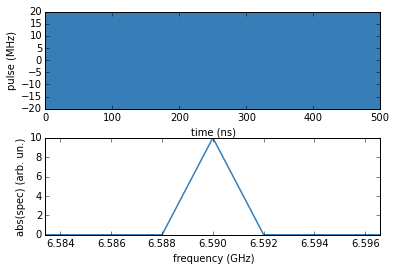

In [13]:
guess_pulse.show()

In [14]:
%%px --targets 0
config, params = read_config('./test_constraint/CPH0013/config')
propagate(write_run=write_run, config=config, params=params,
          pulse=read_guess_pulse('./test_constraint/CPH0013/'), 
          commands=commands, runfolder='./test_constraint/CPH0013_prop')

In [17]:
U_guess = QDYN.gate2q.Gate2Q(file="./test_constraint/CPH0013_prop/U.dat")

In [18]:
U_guess.closest_unitary().concurrence()

0.0079567183258307493

In [19]:
U_guess.pop_loss()

0.010498389296174304

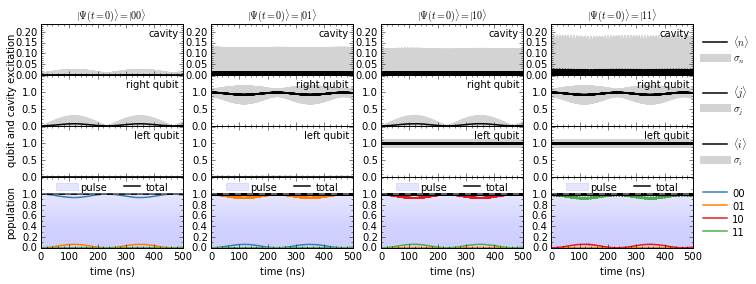

In [20]:
QDYNTransmonLib.popdyn.PopPlot('./test_constraint/CPH0013_prop').show()

## Cavity Excitation Induced by Optimized Pulse

We submit `oct.slr` in the `CPH0013` to optimize for 
The gate that comes out of the optimization is:

In [21]:
pulse_opt = Pulse("./test_constraint/CPH0013/pulse.dat")

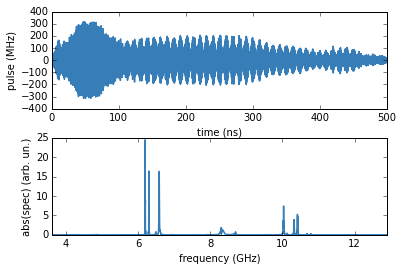

In [22]:
pulse_opt.show()

In [23]:
pulse_opt.preamble

['# OCT iter        531;   J_T =   6.847938382187E-02;   pulse_id =          1']

In [24]:
U_opt = QDYN.gate2q.Gate2Q(file="./test_constraint/CPH0013/U.dat")

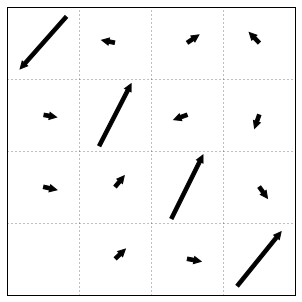

In [25]:
U_opt.arrow_plot()

In [26]:
U_opt.concurrence()

0.97360659531852856

In [27]:
U_opt.pop_loss()

0.05488477426011662

We assume the optimized pulse has been propagated by submitting `prop.slr`, and the resulting `U.dat` and population dynamics files are currently in the runfolder

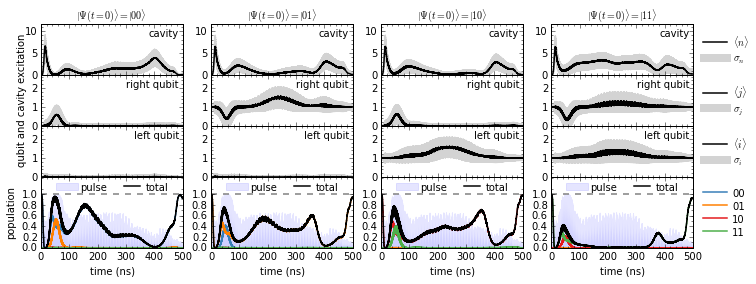

In [28]:
QDYNTransmonLib.popdyn.PopPlot('./test_constraint/CPH0013').show()

Is this converged with respect to the number of qubit and cavity levels?

In [33]:
%%px --targets 0
config, params = read_config('./test_constraint/CPH0013/config')
converged_propagate(write_run=write_run,
              config=config, params=params,
              pulse=Pulse("./test_constraint/CPH0013/pulse.dat"), 
              commands=commands, runfolder='./test_constraint/CPH0013_prop');

In [34]:
U_converged = QDYN.gate2q.Gate2Q(file="./test_constraint/CPH0013_prop/U.dat")

In [35]:
QDYN.linalg.norm(U_opt-U_converged)

0.00031871504037455294

In [36]:
U_converged.concurrence()

0.97359459325818609

In [37]:
U_converged.pop_loss()

0.0548008875972823

In [38]:
! cat ./test_constraint/CPH0013/config | grep n_qubit
! cat ./test_constraint/CPH0013_prop/config | grep n_qubit

user_ints: n_qubit = 5, n_cavity = 20
user_ints: n_qubit = 6, n_cavity = 30


Yes, propagation is converged

## Optimization with state-dependent constraint

We have set up `./test_constraint/CPH0013_constr` to run the same optimization with a state-dependent constraint.
This is achieved by

*   Setting `dissipation=T` in the config
*   Setting `kappa=1.6_MHz` in the config
*   Generating the Hamiltonian with `tm_en_gh --dissipation` in `oct.slr` and `prop.slr`

We run `oct.slr` for the optimization (changing `oct_lambda_a` after a few iterations). Then, we propagate by running `prop.slr`.

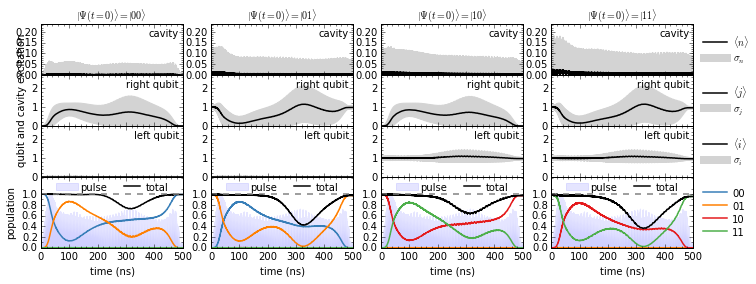

In [39]:
QDYNTransmonLib.popdyn.PopPlot('./test_constraint/CPH0013_constr').show()

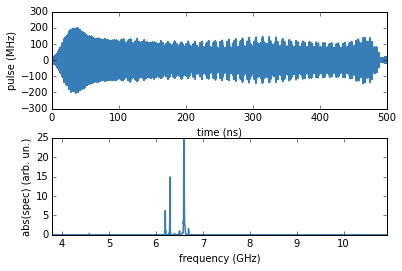

In [40]:
pulse_constr = Pulse("./test_constraint/CPH0013_constr/pulse.dat")
pulse_constr.show()

In [41]:
pulse_constr.preamble

['# OCT iter        533;   J_T =   4.862105211131E-01;   pulse_id =          1']

In [42]:
U_constr = QDYN.gate2q.Gate2Q(file="./test_constraint/CPH0013_constr/U.dat")

In [43]:
U_constr.closest_unitary().concurrence()

0.059780314663978117

In [44]:
U_constr.pop_loss()

0.025484711364844537